# Introduction to CNNs

## Goals:

- learn typical layers
- learn how to count the trainable parameters
- implement a simple CNN

# Import dependencies

In [1]:
# Import dependencies
import numpy as np
from tensorflow import keras
from keras import layers
import tensorflow as tf

# set seed
keras.utils.set_random_seed(42)


# Dataset

## The MNIST dataset

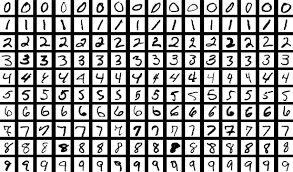

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

In [2]:
# load the data and divide it into train/test split
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Let's visualize the first row of the training set to see how it appears.

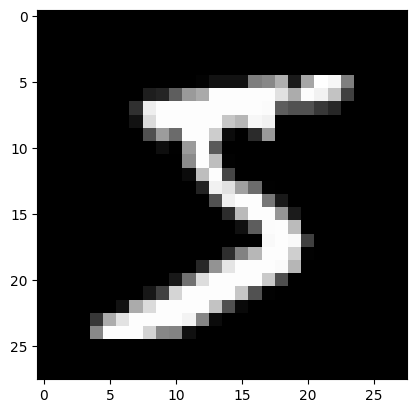

Label: 5


In [5]:
# Show the first element
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap="gray")
plt.show()
print(f"Label: {y_train[0]}")



### Data preparation

We now normalize the images of the dataset so that their range is between 0 and 1

In [ ]:
# Scale images into the [0 1] range | Normalization
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images with size (28,28,1)
# Le CNN necessitano le immagini con 3 dimensioni: width, height, channels
# -1 => Expand last dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# check shape
print(x_train.shape, x_test.shape)


(60000, 28, 28, 1) (10000, 28, 28, 1)


For multi-class problems, we need to convert the label representing the class into a one-hot vector.

In [8]:
# convert class array into one-hot representation
# (1 element per class in the vector with flags 0/1)
num_classes = 10;
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# we have seen this class is 5
print(y_train.shape)
print(y_train[0])


(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Model definition

In order to define the CNN for our classification problem, we use:

- Convolutional layers: Si applica un filtro, cella per cella e poi si sommano tutti i valori calcolati con il prodotto.
- Pooling layers: Reduce dimensions of the samples
  - Di solito è trial and error per decidere tra maxpooling e average pooling
- Flatten layer: appiattisce i tensori multidimensionali in un singolo vettore unidimensionale.
- Fully-connected layers

## Convolutional layer

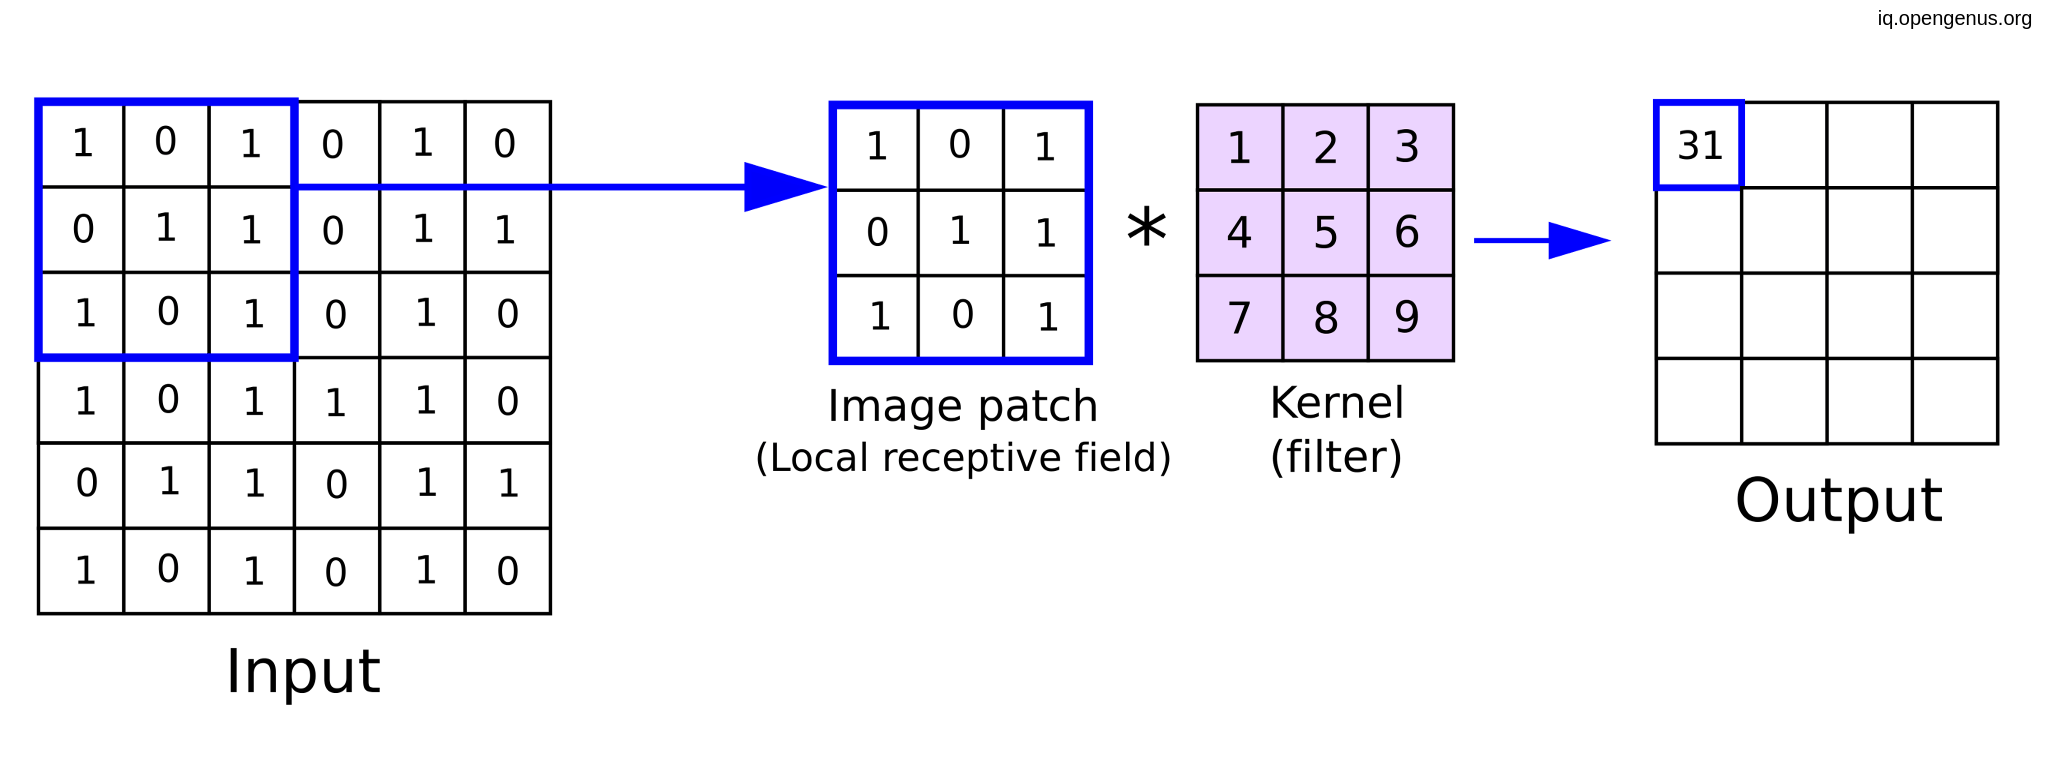

## Pooling layers

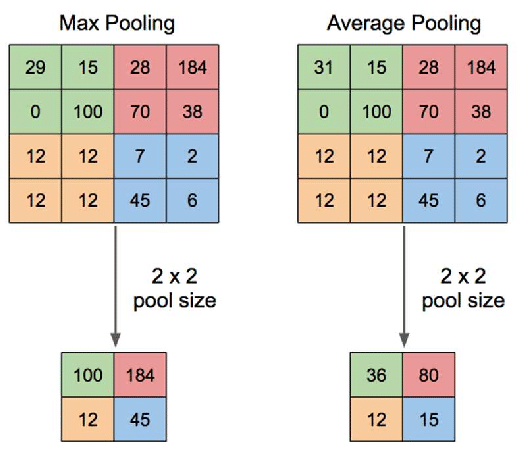

In [10]:
# Model/data parameters
num_classes = 10
# Dimensions of the image
input_shape = (28,28,1) 

model = keras.Sequential([
	keras.Input(shape=input_shape),
	# Kernel size: you don't have to specify the second dimension because it is assumed to be square
	# L'output di questo conv layer sarà 26x26x32 -> 32 per il numero di filtri & 26 perché il filtro rimuove il bordo (-2) siccome è 3x3.
	layers.Conv2D(32, kernel_size=3, activation='relu'),
	# pool_size: dimensione su cui effettuare il pooling
	layers.MaxPool2D(pool_size=2),

	# un altro convolutional + pooling per diminuire la spazialità e aumentare la profondità del tensore
	layers.Conv2D(64, kernel_size=3, activation='relu'),
	layers.MaxPool2D(pool_size=2),

	# Convert the tensor into a 1-dimensional layer
	layers.Flatten(),
	
	layers.Dropout(0.5),
	# Fully connected output to softmax on 10 units (10 classes)
	layers.Dense(10, activation='softmax')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

Why the second convolutional layer has 18496 parameters?

This is because the number of input channels is 32, we have 64 kernels of size 3x3, **each of which has 32 channels**. Hence, the total number of parameters is 32x64x3x3=18432+64=18496, where 64 is the bias (1 per kernel, in our case 64).

# Training

Let's train our model! For this, we need to specify the loss function we want to optimize. A common choice is the [categorical cross-entropy loss](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). In addition, we monitor the accuracy to check the performance of our model.

In [11]:
batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

# Validation used to select the best model during training
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8814 - loss: 0.3876 - val_accuracy: 0.9714 - val_loss: 0.0981
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9639 - loss: 0.1175 - val_accuracy: 0.9803 - val_loss: 0.0670
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9724 - loss: 0.0889 - val_accuracy: 0.9837 - val_loss: 0.0543
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9770 - loss: 0.0735 - val_accuracy: 0.9856 - val_loss: 0.0505
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9791 - loss: 0.0651 - val_accuracy: 0.9869 - val_loss: 0.0436


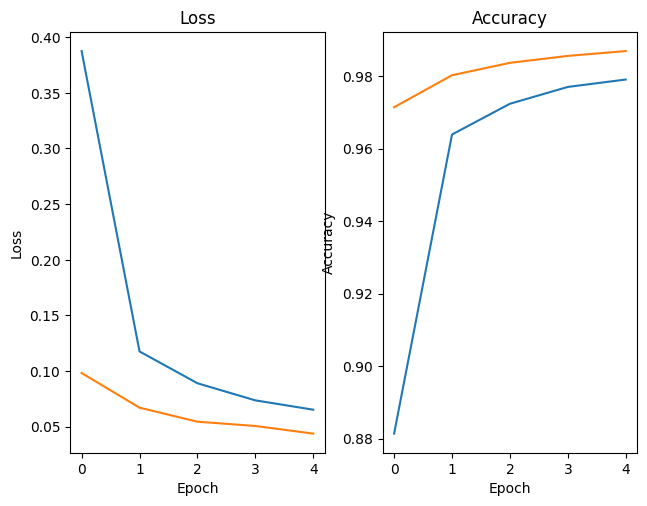

In [12]:
def plot_performance(history):
  fig, ax = plt.subplots(1, 2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  valid_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss)
  ax[0].plot(valid_loss)
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].plot(train_acc)
  ax[1].plot(valid_acc)
  plt.show()

plot_performance(history)


# Evaluation

Let's see the performance we obtain on the test set.

Dovrebbe risultare simile a quella del validation set, siccome entrambi non sono utilizzati per il training

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("test loss: ", score[0])
print("test accuracy: ", score[1])

test loss:  0.03595293313264847
test accuracy:  0.9883000254631042


# The smallest model

In [20]:
model_small = keras.Sequential([
	keras.Input(shape=input_shape),
	layers.AveragePooling2D(pool_size=28),
	layers.Flatten(),
	layers.Dense(num_classes, activation='softmax')
])

model_small.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ average_pooling2d               │ (None, 1, 1, 1)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_small.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_small.fit(x_train, y_train, batch_size=batch_size, epochs=25, validation_split=0.2)


Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1784 - loss: 2.2775 - val_accuracy: 0.1768 - val_loss: 2.2769
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1818 - loss: 2.2737 - val_accuracy: 0.1782 - val_loss: 2.2732
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1841 - loss: 2.2701 - val_accuracy: 0.1795 - val_loss: 2.2697
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1854 - loss: 2.2665 - val_accuracy: 0.1806 - val_loss: 2.2662
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1867 - loss: 2.2630 - val_accuracy: 0.1814 - val_loss: 2.2628
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1875 - loss: 2.2596 - val_accuracy: 0.1821 - val_loss: 2.2595
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1885 - loss: 2.2562 - val_accuracy: 0.1828 - val_loss: 2.2562
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1896 - loss: 2.2530 - val_accuracy: 0.

Non ci possiamo aspettare un buon risultato perché stiamo riassumendo l'immagine con un solo layer di pooling.
Quello che aiuta è utilizzare average pooling invece che max: il max di un immagine la maggior parte delle volte è sempre 1 mentre la media di tutti i valori nell'immagine è più discriminativo

# Feature extraction

## Goals:

- learn how to extract features from a pre-trained CNN, such as VGG16
- learn how to use the extract features to train a SVM for classification

Molti più convolutional e pooling layer -> molto difficile da trainare da zero

# Get features from pre-trained VGG-16 network

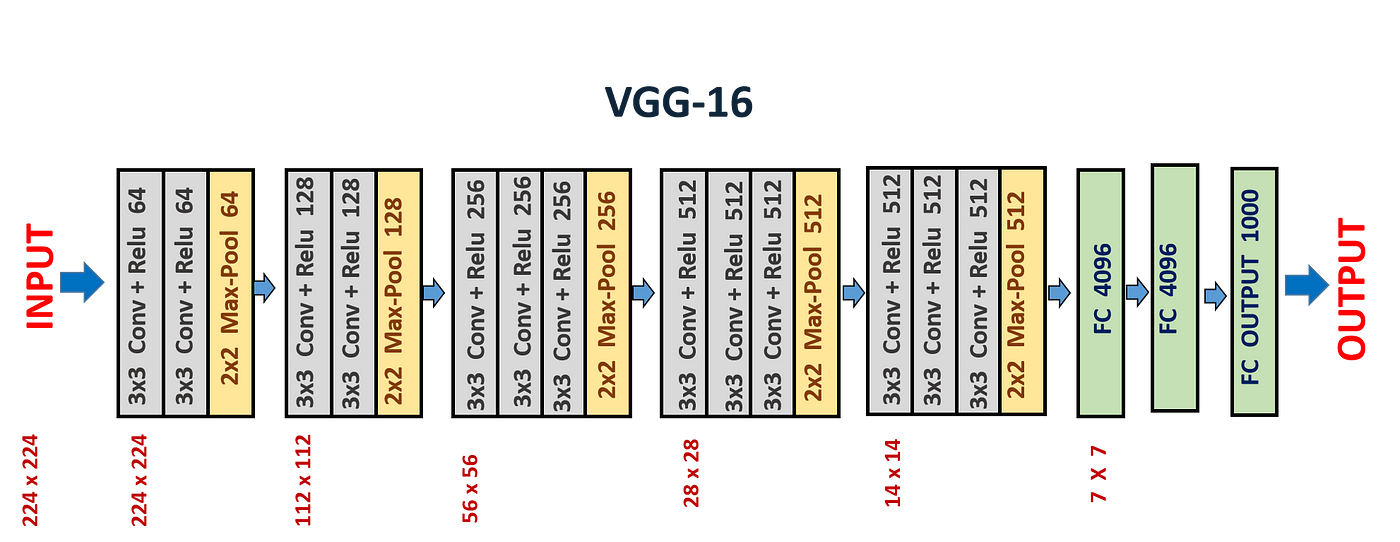

In [24]:
# import dependencies
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

# I dati in input devono essere normalizzati allo stesso modo di quelli utilizzati durante il training su imagenet

In [25]:
# load vgg model
# non abbiamo bisogno di includere il top perché non abbiamo bisogno della fully connected part ma solo di quella convoluzionale
vgg_model = VGG16(include_top=False, weights='imagenet')

vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Let's now select the cut point of the pre-trained VGG16. In particular, we select the output of the pooling layer in the 5° convolutional block.

In [ ]:
# select the cut point | seleziono l'ultimo layer della parte convoluzionale
last_layer = vgg_model.get_layer(name="block5_pool")

# Manteniamo dall'input fino all'ultimo layer convoluzionale
# create the new model for feature extraction
vgg_feature_extractor = keras.Model(inputs=vgg_model.input, outputs=last_layer.output)

vgg_feature_extractor.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Now that we created the model, let's use it to extract the features of the MNIST images. Since the feature extraction model based on VGG16 expects the input to have spatial resolution of 224x224, we need to reshape the images. We then need to convert grayscale images into RGB images.

In addition, we have to apply the same preprocessing that was applied when the network was trained on the ImageNet dataset (including channel convertion, z-normalization etc).

We only use the first 1000 images due to memory constraints.

In [29]:
# Get the first 1000 images from both train and test sets
x_train_small = x_train[:1000]
y_train_small = y_train[:1000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]

# Resize to 224x224
x_train_small_res = tf.image.resize(x_train_small, [224, 224])
x_test_small_res = tf.image.resize(x_test_small, [224, 224])

# 2. Convert grayscale → RGB 
# Replicate gray channel 3 times
x_train_small_rgb = tf.image.grayscale_to_rgb(x_train_small_res)
x_test_small_rgb = tf.image.grayscale_to_rgb(x_test_small_res)


# apply preprocessing
# z-normalization: normalizzazione applicata per VGG on imagenet
x_train_prep = preprocess_input(x_train_small_rgb)
x_test_prep = preprocess_input(x_test_small_rgb)

# check the resulting shape
print(x_train_prep.shape, x_test_prep.shape)


(1000, 224, 224, 3) (1000, 224, 224, 3)


We are now ready to extract the VGG16 features from the input image.

In [30]:
# get features, use the vgg to obtain convolutional data
x_train_features = vgg_feature_extractor.predict(x_train_prep)
x_test_features = vgg_feature_extractor.predict(x_test_prep)


# check shape
print(x_train_features.shape, x_test_features.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step
(1000, 7, 7, 512) (1000, 7, 7, 512)


Since we want to train a SVM classifier, we have to convert the multi-dimensional array into a vector. For this, we just flatten the last dimensions.

In [ ]:
# convert from 1000x7x7x512 to 1000x25088
# Prima dimensione specificata (1000 elementi) il resto sono computate internalmente dalla funzione
x_train_features_flattened = x_train_features.reshape(1000, -1)
x_test_features_flattened = x_test_features.reshape(1000, -1)

# check result
print(x_train_features_flattened.shape, x_test_features_flattened.shape)

(1000, 7, 7, 512) (1000, 7, 7, 512)


# Classification with SVM

Let's now create a simple SVM classifier using the sklearn library (you should know it from the Machine Learning course!).

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define the SVM classifier
svm_classifier = SVC(kernel='linear', C=1)

# Convert the labels from 1-hot representation back to 1-D array
y_train_small = np.argmax(y_train_small, axis=1)
y_test_small = np.argmax(y_test_small, axis=1)

# Train the SVM
svm_classifier.fit(x_train_features_flattened, y_train_small)

SVC(C=1, kernel='linear')

New the SVM is trained, let's see the results on the test set

In [33]:
predictions = svm_classifier.predict(x_test_features_flattened)
print(classification_report(y_test_small, predictions))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91        85
           1       0.97      0.98      0.98       126
           2       0.89      0.93      0.91       116
           3       0.94      0.89      0.91       107
           4       0.92      0.90      0.91       110
           5       0.88      0.92      0.90        87
           6       0.93      0.93      0.93        87
           7       0.90      0.87      0.88        99
           8       0.92      0.80      0.86        89
           9       0.84      0.86      0.85        94

    accuracy                           0.91      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.91      0.91      0.91      1000



Let's finally compare the results we have just obtained with the results we obtain if we simply use the images "as-is", i.e., simply flattening their shape to obtain a 1-D array from a 2-D one.
Quindi le feature estratte dal VGG sono più significative che utilizzare le immagini direttamente

In [35]:
svm_classifier_simple = SVC(kernel='linear', C=1)

# Flatten the training features
x_train_images_small = x_train_small.reshape(1000, -1)
print(x_train_images_small.shape)

# Train the classifier
svm_classifier_simple.fit(x_train_images_small, y_train_small)

(1000, 784)


SVC(C=1, kernel='linear')

In [36]:
# Flatten the test features
x_test_images_small = x_test_small.reshape(1000, -1)

# Use the trained classifier to make predictions
predictions = svm_classifier_simple.predict(x_test_images_small)
print(classification_report(y_test_small, predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93        85
           1       0.96      0.99      0.98       126
           2       0.88      0.90      0.89       116
           3       0.87      0.77      0.82       107
           4       0.86      0.85      0.86       110
           5       0.69      0.83      0.75        87
           6       0.89      0.89      0.89        87
           7       0.80      0.83      0.82        99
           8       0.87      0.70      0.78        89
           9       0.76      0.81      0.78        94

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



As we can see, the results obtained using features from VGG network are better then simply flattening the images.

**ASSIGNMENT**: try to obtain the best performance on MNIST using a custom CNN (implemented by you) with a max of 7K weights.

Deadline: 28/11/2025 at 23:59.